# Applied Data Science Assignment - NBA Prediction

## 1.0 Logistic Regression for Predicting "Playoffs"

After we have now consolidated our data from a CSV File and from a NBA Website into a Dataframe, we would like to consider
the appropriate alogirthm for our prediction. We would like to predict what the probability is, that a NBA Team is qualifying for playoffs based on this historical data from 2011 to 2022. 

### 1.1 Data transformation before prediction

In [41]:
#Before we jump into the development of a ML model,
#we would also like to transform the categorical variable "playoffs" into binary for "True" and "False"

# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(final_df['playoffs'])
 
# printing label
label

# removing the column 'Purchased' from df
# as it is of no use now.
final_df.drop("playoffs", axis=1, inplace=True)
 
# Appending the array to our dataFrame
# with column name 'playoffs'
final_df["playoffs"] = label

In [42]:
#show df after transformation
final_df

final_df.isna().sum()

season              0
Team                0
age                 0
w                   0
l                   0
pw                  0
pl                  0
mov                 0
sos                 0
srs                 0
o_rtg               0
d_rtg               0
n_rtg               0
pace                0
f_tr                0
x3p_ar              0
ts_percent          0
e_fg_percent        0
tov_percent         0
orb_percent         0
ft_fga              0
opp_e_fg_percent    0
opp_tov_percent     0
opp_drb_percent     0
opp_ft_fga          0
attend              0
attend_g            0
Conf                0
Div                 0
W_L_Per             0
MOV_A               0
ORtg_A              0
DRtg_A              0
NRtg_A              0
Rk                  0
playoffs            0
dtype: int64

### 1.2 Correlation Matrix

In a first step, we really want to see how the correlation between the variables are since we have many variables. Therefore,
we decided to do a correlation matrix in order to eliminate high correlating variables between eachother. We want also to see
how the future target variable of our model correlates with the other variables.

According Cooke, McTeague, Silva, and Yee (n.d.) argue that for predicting "playoffs" with logistic regression, the most important variables are:
- Defensive rebounds (DRB)
- Steals (STL)
- Turnovers (TOV) 

Offensive & Defensive Effective FG %
Offensive & Defensive Turnover %
Offensive & Defensive Rebounding %
Free Throw %

Cooke, D., McTeague, S., Silva, D., & Yee, H. (n.d.). Predicting the 2020 NBA Playoffs. Retrieved from https://hanesy.github.io/NBA_Playoffs/




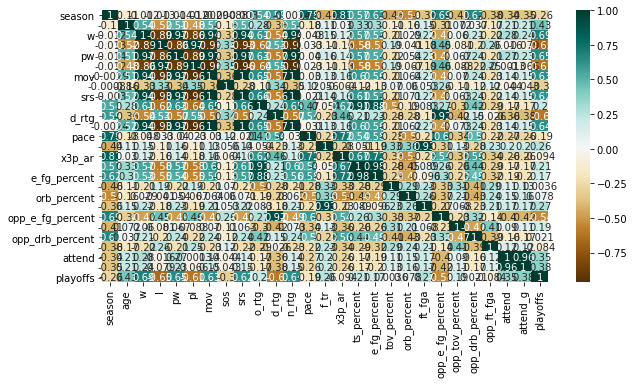

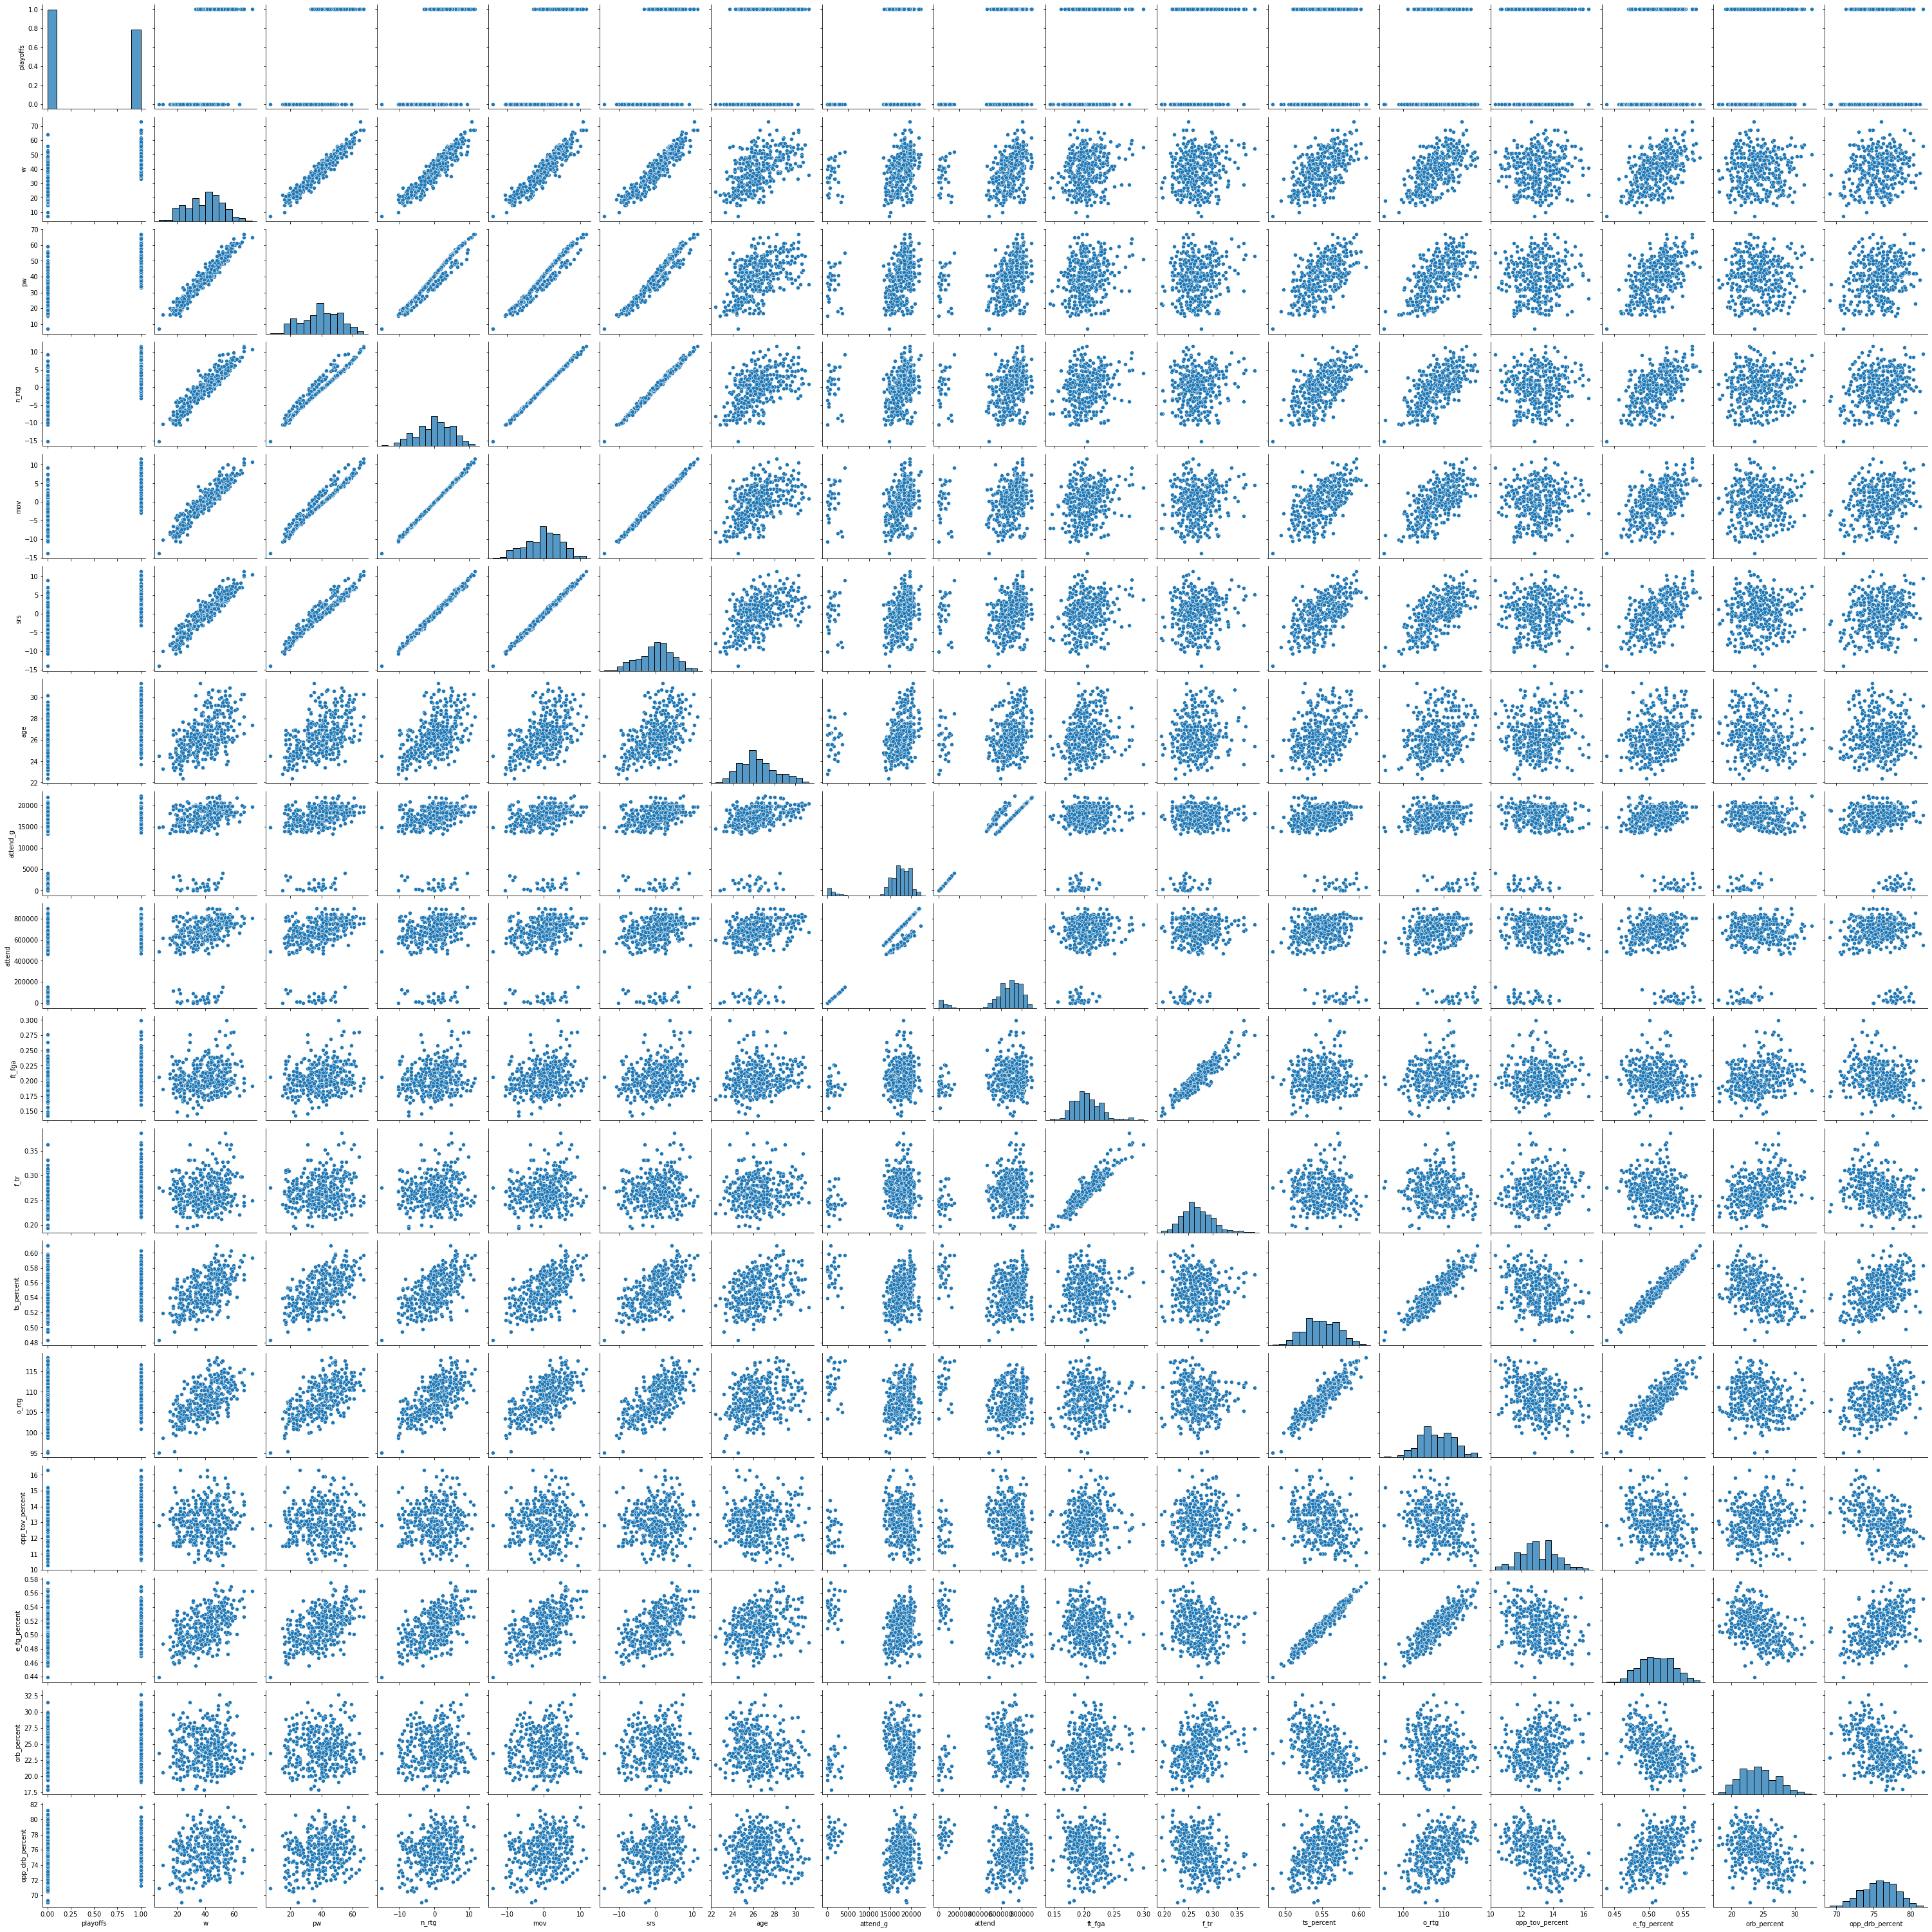

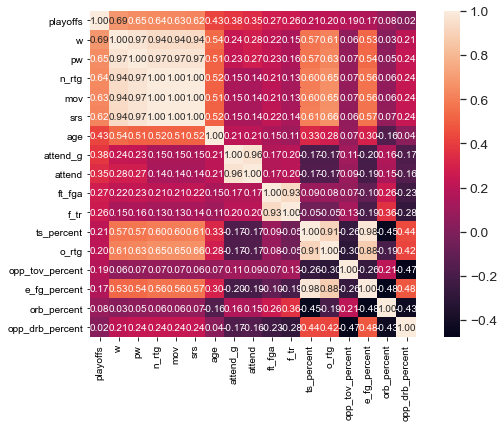

In [43]:
#Correlation Matrix for identifying correlating variables
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(10,5))
c = final_df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

#Correlation plot to see correlation between the variables and playoffs
cols1 = ['playoffs', 'w', 'pw', 'n_rtg', 'mov', 'srs', 'age', 'attend_g', 'attend', 'ft_fga', 'f_tr', 'ts_percent', 'o_rtg',
        'opp_tov_percent', 'e_fg_percent', 'orb_percent', 'opp_drb_percent']
sns.pairplot(final_df[cols1], height=2.5)
plt.show()

#we want also to see how our target variable "playoffs" correlates with other variables (the 17 highest correlating variables)
corrmat = final_df.corr()
k = 17
cols = corrmat.nlargest(k, 'playoffs')['playoffs'].index
f, ax = plt.subplots(figsize=(10,6))
cm = np.corrcoef(final_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We will set the threshold for diminshing redundate variables to >0.75 to not artifically interfere with the data to be considered.

The first correlation matrix is overloaded and does not provide much insights into the correlations between the matrix.
The second correlation matrix, which shows the 17 highest correlating variables with "playoffs" among others. 

* We see that the highest correlation of playoffs is with #wins ('w'), which was thought to be higher. We see also that "w", "pw", "n_rtg", "mov", "srs" highly correlate with each other. 
   + We keep **"srs"** and diminish **"w"**, **"pw"**, **"n_rtg"**, and **"mov"** (srs lowest correlation with "playoffs")

* High correlation between "attend" and "attend_g".
   + We diminish **"attend_g"** since it does not seem do make differention which one

* High correlation between "f_tr" and "ft_fga"
   + We diminish **"f_tr"** (freethrows) since **"ft_fga"** (freethrow for field goal attemps) is more specific

* High correlation between "e_fg_percent", "ts_percent", "o_rtg"
   + We diminish **"e_fg_percent"** ("Effective Field Goal Percentage"), **"ts_percent"** ("True Shooting Percentage"), we keep **"o_rtg"** ("Offensive Rating") since it incorporates the other two

In a next step, we want to take a closer look at all the correlations between the variables over 0.88>0.75 since not displayed in the correlation matrix. But we drop first the named variables above.

In [44]:
#Drop related high correlating variables and create correlation df
df_corr = final_df.drop(['w','pw','n_rtg','mov','attend_g','f_tr','e_fg_percent','ts_percent'],axis=1)

#Showcasing all the correlations between the variables above 0.75 with the droped variables
corr = df_corr.corr().drop_duplicates() # df is the pandas dataframe
corr[corr == 1] = 0
c1 = corr.abs().unstack().sort_values()
display(c1[c1> 0.75])

pace              season              0.779183
season            pace                0.779183
x3p_ar            season              0.814290
season            x3p_ar              0.814290
d_rtg             opp_e_fg_percent    0.923139
opp_e_fg_percent  d_rtg               0.923139
l                 srs                 0.928850
srs               l                   0.928850
pl                srs                 0.958295
srs               pl                  0.958295
pl                l                   0.968714
l                 pl                  0.968714
dtype: float64

We see further high correlations between variables and some are further considered to be dropped:

* High correlation between "l" ("Loss") , "pl" (#players), "srs" (Simple Rating System)
  * We diminish **"l"** and **"pl"** and keep **"srs"** since it gives some indication about schedule itensity
* High correlation between "opp_e_fg_percent" (Opponents Effective Field Goal Rating) and "d_rtg" (Defense Rating)
  * We diminish **"opp_e_fg_percent"** and keep **"d_rtg"** since it is more team related and gives more indication about defense of the team than "opp_e_fg_percent"
* We do not diminish "season", "pace", or "x3p_ar" due to missing legitmacy. Also correlation almost on threshold 0.75. 

In [45]:
#We drop again high correlting variables as descriped above
df_corrfinal = df_corr.drop(['l','pl','opp_e_fg_percent'],axis=1)

#Show the final df for variables to be considere for the logistic regression model
df_corrfinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 1 to 360
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           360 non-null    int64  
 1   Team             360 non-null    object 
 2   age              360 non-null    float64
 3   sos              360 non-null    float64
 4   srs              360 non-null    float64
 5   o_rtg            360 non-null    float64
 6   d_rtg            360 non-null    float64
 7   pace             360 non-null    float64
 8   x3p_ar           360 non-null    float64
 9   tov_percent      360 non-null    float64
 10  orb_percent      360 non-null    float64
 11  ft_fga           360 non-null    float64
 12  opp_tov_percent  360 non-null    float64
 13  opp_drb_percent  360 non-null    float64
 14  opp_ft_fga       360 non-null    float64
 15  attend           360 non-null    float64
 16  Conf             360 non-null    object 
 17  Div             

 * sos = **Strength of Schedule**: a rating of strength of schedule. The rating is denominated in points above/below average, where zero is average. A positive number indicates a harder than average schedule
 * srs = **Simple Rating System**: a rating that takes into account average point differential and strength of schedule. The rating is denominated in points above/below average, where zero is average
 * o_rtg = Offensive Rating
 * d_rtg = Defensive Rating
 * pace = Pace factor is an estimate of the number of possessions per 48 minutes by a team.
 * x3p_ar = **do not know**
 * tov_percent = Turnover percentage is an estimate of turnovers per 100 plays
 * orb_percent =  Offensive rebound percentage is an estimate of the percentage of available offensive rebounds a player grabbed while he was on the floor.
 * opp_tov_percent = Turnover percentage is an estimate of turnovers per 100 plays (Opponent)
 * opp_drb_percent = Defensive rebound percentage is an estimate of the percentage of available defensive rebounds a player grabbed while he was on the floor (Opponent)
 * opp_ft_fga = Freethrow - Field Goal Attempts
 * attend = #spectators
 * Conf = Conference
 * Div = Division
 * W_L_Per = Win/Loss Percentage
 * MOV_A = Margin of Victory
 * ORTG_A = Offensive Rating
 * DRtg_A = Defensive Rating
 * Nrtg_A = Net Rating - Measures a team's point differential per 100 possessions. On player level this statistic is the team's point differential per 100 possessions while they are on court. (Calc = Offense Rating - Defense Rating)
 * Rk = Ranking
 * playoffs = playoffs qualification

### 1.3 Building the logistic regression model

#### 1.3.1 Model 1: Own selection of parameters

In the first model, we tried to predict if a team's playoff qualification based on general variables, meaning not game stats specific. This means we considered the **"Offensive Rating"**, **"Defense Rating"**, **"Attending spectators in favor of the team"**, **"Win/Loss percentage"**, **"Team's Ranking"**, and schedule itensity metrices, such as **"Strength of Schdule (sos)"**, **"Simple Rating System"**.


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [47]:
#select needed colums for model
# ORtg/A = Adjusted Offensive Rating = Points scored per 100 Possesion
# DRtg/A = Adjusted Defensive Rating = Points allowed per 100 Possesion

#df_NBA = final_df[['ORtg_A','DRtg_A','playoffs']]

df_NBA = final_df

In [61]:
#define target value and split test data
#for X we dropped columnes which are not relevant or from previous correlation analysis
X = final_df.filter(['o_rtg','d_rtg','attend','W_L_Per', 'Rk', 'sos', 'srs'],axis=1).values
#X = df_NBA.drop(['playoffs','ts_percent','attend_g','n_rtg','srs','f_tr','pw','pl','d_rtg','Team','Conf','Div','season'],axis=1).values
y = df_NBA['playoffs'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state = 99)

In [62]:
#The input data is not standardised (standardise the data means transform the data so that they have mean 0 and std dev 1). This is a good practise, especially when data have very different ranges.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

LogisticRegression()

In [64]:
print(log_reg.coef_)
print(log_reg.intercept_)

[[-0.55227549 -0.49767289  0.86129928  2.92533145 -0.2735316  -0.27448287
  -0.39191311]]
[-0.47735753]


In [65]:
y_pred = log_reg.predict(X_test)
y_pred

y_proba = log_reg.predict_proba(X_test)

y_pred = log_reg.predict(X_test)

prediction_df = pd.DataFrame(np.c_[y_proba,y_pred], columns = ['Probability not qualifying',
                                                                'Probability qualifying',
                                                                'Predicted class'])
#Putting the teams into a seperate df to combine it with the prediction
#teams_df = final_df.filter(['Team','season'],axis=1)

#completion = [teams_df, prediction_df]

#finalprediction_df = pd.concat(completion)
#finalprediction_df = teams_df.join(prediction_df)

#finalprediction_df
prediction_df

,Probability not qualifying,Probability qualifying,Predicted class
0,0.586355,0.413645,0.0
1,0.015705,0.984295,1.0
2,0.528685,0.471315,0.0
3,0.990945,0.009055,0.0
4,0.005173,0.994827,1.0
...,...,...,...
67,0.996112,0.003888,0.0
68,0.039258,0.960742,1.0
69,0.977833,0.022167,0.0
70,0.917761,0.082239,0.0


In [66]:
mean_accuracy = log_reg.score(X_test, y_test)
print("The accuracy of your model is {0}%".format(np.round(mean_accuracy*100),2))

The accuracy of your model is 93.0%


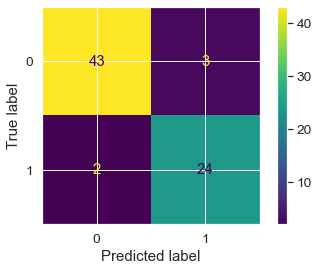

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # for this plot sklearn >= 1.0.1 is needed

cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_reg.classes_)
disp.plot()
plt.show()

In [69]:
#  Showing all Performance Metrics from previous Confusion Matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[43  3]
 [ 2 24]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        46
           1       0.89      0.92      0.91        26

    accuracy                           0.93        72
   macro avg       0.92      0.93      0.93        72
weighted avg       0.93      0.93      0.93        72



**Conclusion 1. Model**:
In general, we do have a high accuracy with 93%. Additionally, the high precision and recall lead to a high F1 score, which tells as that the model performs very well. I fact, it is really difficult to get a high precision and recall in practice, also considering the increased number of variables used for the prediction. 

#### 1.3.2 Model 2: Considering games related variables only

In [121]:
#define target value and split test data
#for X we dropped columnes which are not relevant or from previous correlation analysis
X2 = final_df.filter(['pace','tov_percent','orb_percent','orb_tov_percent','opp_drb_percent','opp_ft_fga','Nrtg_A'],axis=1).values
#X = df_NBA.drop(['playoffs','ts_percent','attend_g','n_rtg','srs','f_tr','pw','pl','d_rtg','Team','Conf','Div','season'],axis=1).values
y2 = df_NBA['playoffs'].values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.20, random_state = 99)

In [122]:
#The input data is not standardised (standardise the data means transform the data so that they have mean 0 and std dev 1). This is a good practise, especially when data have very different ranges.
scaler = StandardScaler()
X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

In [123]:
log_reg2 = LogisticRegression()

log_reg2.fit(X2_train, y2_train)

LogisticRegression()

In [124]:
print(log_reg2.coef_)
print(log_reg2.intercept_)

[[-0.40093879 -0.05932318  0.11186455  0.16942562 -0.17930645]]
[-0.14492423]


In [125]:
y_pred2 = log_reg2.predict(X2_test)
y_pred2

y_proba2 = log_reg2.predict_proba(X2_test)

y_pred2 = log_reg2.predict(X2_test) 

prediction_df2 = pd.DataFrame(np.c_[y_proba2,y_pred2], columns = ['Probability not qualifying',
                                                                'Probability qualifying',
                                                                'Predicted class'])
#Putting the teams into a seperate df to combine it with the prediction
#teams_df = final_df.filter(['Team','season'],axis=1)

#completion = [teams_df, prediction_df]

#finalprediction_df = pd.concat(completion)
#finalprediction_df = teams_df.join(prediction_df)

#finalprediction_df
prediction_df2

,Probability not qualifying,Probability qualifying,Predicted class
0,0.463168,0.536832,1.0
1,0.399891,0.600109,1.0
2,0.541780,0.458220,0.0
3,0.633792,0.366208,0.0
4,0.524372,0.475628,0.0
...,...,...,...
67,0.805460,0.194540,0.0
68,0.636138,0.363862,0.0
69,0.544706,0.455294,0.0
70,0.561350,0.438650,0.0


In [126]:
mean_accuracy2 = log_reg2.score(X2_test, y2_test)
print("The accuracy of your model is {0}%".format(np.round(mean_accuracy2*100),2))

The accuracy of your model is 71.0%


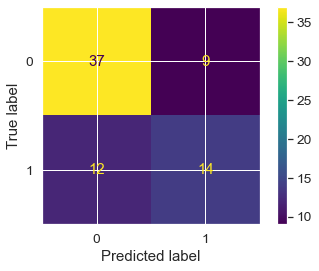

In [127]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # for this plot sklearn >= 1.0.1 is needed

cm2 = confusion_matrix(y2_test, y_pred2, labels=log_reg.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=log_reg.classes_)
disp2.plot()
plt.show()

In [128]:
#  Showing all Performance Metrics from previous Confusion Matrix

print(confusion_matrix(y2_test, y_pred2))
print(classification_report(y2_test, y_pred2))

[[37  9]
 [12 14]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        46
           1       0.61      0.54      0.57        26

    accuracy                           0.71        72
   macro avg       0.68      0.67      0.68        72
weighted avg       0.70      0.71      0.70        72



**Conclusion 2. Model**:
In general, we do have an accuracy of 71%. By taking a look at the confusion matrix, the model has slightly more problems to predict the effective playoff qualification of teams. Precision, recall and F1-Score are good for predicting non-qualifications and pretty average for accurate playoff qualifications. It seems also far to mention, that the random sample included more non-qualification examples.

#### 1.3.3 Model 3: Considering variables from resources

In [129]:
#define target value and split test data
#for X we dropped columnes which are not relevant or from previous correlation analysis
X1 = final_df.filter(['opp_drb_percent','Nrtg_A','tov_percent'],axis=1).values
#X = df_NBA.drop(['playoffs','ts_percent','attend_g','n_rtg','srs','f_tr','pw','pl','d_rtg','Team','Conf','Div','season'],axis=1).values
y1 = df_NBA['playoffs'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.20, random_state = 99)

In [130]:
#The input data is not standardised (standardise the data means transform the data so that they have mean 0 and std dev 1). This is a good practise, especially when data have very different ranges.
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

In [131]:
log_reg1 = LogisticRegression()

log_reg1.fit(X1_train, y1_train)

LogisticRegression()

In [132]:
print(log_reg1.coef_)
print(log_reg1.intercept_)

[[-0.00820316 -0.01612258]]
[-0.13912042]


In [133]:
y_pred1 = log_reg1.predict(X1_test)
y_pred1

y_proba1 = log_reg1.predict_proba(X1_test)

y_pred1 = log_reg1.predict(X1_test) #ADD YOU CODE HERE####

prediction_df1 = pd.DataFrame(np.c_[y_proba1,y_pred1], columns = ['Probability not qualifying',
                                                                'Probability qualifying',
                                                                'Predicted class'])
#Putting the teams into a seperate df to combine it with the prediction
#teams_df = final_df.filter(['Team','season'],axis=1)

#completion = [teams_df, prediction_df]

#finalprediction_df = pd.concat(completion)
#finalprediction_df = teams_df.join(prediction_df)

#finalprediction_df
prediction_df1

,Probability not qualifying,Probability qualifying,Predicted class
0,0.526011,0.473989,0.0
1,0.533272,0.466728,0.0
2,0.529153,0.470847,0.0
3,0.535437,0.464563,0.0
4,0.534346,0.465654,0.0
...,...,...,...
67,0.536933,0.463067,0.0
68,0.543553,0.456447,0.0
69,0.537165,0.462835,0.0
70,0.530439,0.469561,0.0


In [134]:
mean_accuracy1 = log_reg1.score(X1_test, y1_test)
print("The accuracy of your model is {0}%".format(np.round(mean_accuracy1*100),2))

The accuracy of your model is 64.0%


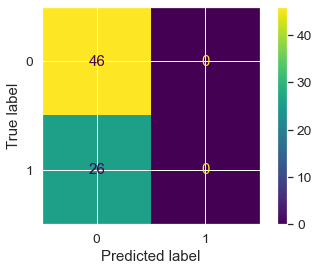

In [135]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # for this plot sklearn >= 1.0.1 is needed

cm1 = confusion_matrix(y1_test, y_pred1, labels=log_reg.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=log_reg.classes_)
disp1.plot()
plt.show()

In [136]:
#  Showing all Performance Metrics from previous Confusion Matrix

print(confusion_matrix(y1_test, y_pred1))
print(classification_report(y1_test, y_pred1))

[[46  0]
 [26  0]]
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        46
           1       0.00      0.00      0.00        26

    accuracy                           0.64        72
   macro avg       0.32      0.50      0.39        72
weighted avg       0.41      0.64      0.50        72



C:\Users\Startklar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Startklar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Startklar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Conclusion 3. Model**:


In general, we do have a high accuracy with 64%. By taking a closer look at the confusion matrix, we see that the performance is bad and the model was not able to predict playoff qualification correctly (only no qualifications). The model is biased towards non-qualification. If we look at the probabilities, it is always between approximately 50%/50% for both classes, but decides for non-qualification all the time. Therefore all the other measure such as precision, recall and F1 score are bad. Not a model to further consider. 